In [1]:
import pandas as pd
import seaborn as sns

In [2]:
# https://machinelearningmastery.com/dont-use-random-guessing-as-your-baseline-classifier/
# https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

In [3]:
df_cargos_desc = pd.read_excel("cargos_categorias.xlsx", sheet_name=0)
cargos_list = list(df_cargos_desc["CÓDIGO"])
#cargos_list

In [4]:
data = pd.read_csv("res_completo.csv", index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 0 to 283
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id_resol             284 non-null    object
 1   año                  284 non-null    int64 
 2   cargos               284 non-null    object
 3   códigos              283 non-null    object
 4   Empresa denunciada   284 non-null    object
 5   Multas               284 non-null    object
 6   Medidas correctivas  284 non-null    object
 7   dec_fav_denunciante  284 non-null    int64 
 8   cargos limpio        284 non-null    object
dtypes: int64(2), object(7)
memory usage: 22.2+ KB


In [5]:
# crear lista de códigos de cargos multicategoricos
data["códigos"] = data["códigos"].apply(lambda x: x.split(",") if isinstance(x, str) else [])

In [6]:
import re

def limpieza_texto(string):
    string = string.lower()
    string = string.replace("\n", " ")
    list_words = re.findall(r'[a-z0-9ñáéíóúü-]+', string)
    string = " ".join(list_words)
    return string

data["cargos limp 1"] = data["cargos"].apply(limpieza_texto)


In [7]:
data

,id_resol,año,cargos,códigos,Empresa denunciada,Multas,Medidas correctivas,dec_fav_denunciante,cargos limpio,cargos limp 1
0,0002-2020/SPC-INDECOPI,2020,Luego de contratar los servicios de la denunci...,[ser1],EMPRESA DE TRANSPORTES TURISMO SEÑOR DE ATACO ...,0,0,0,luego contratar servicios denunciada 26 octubr...,luego de contratar los servicios de la denunci...
1,0894-2020/SPC-INDECOPI,2020,La cláusula 11 incluida en sus boletos de viaj...,[c1],EMPRESA CAPLINA DE TRANSPORTES TURÍSTICOS INTE...,1 UIT,Consignar mecanismos de indemnización por pérd...,1,cláusula 11 incluida boletos viaje establecía ...,la cláusula 11 incluida en sus boletos de viaj...
2,0893-2020/SPC-INDECOPI,2020,La cláusula 11 incluida en sus boletos de viaj...,[c1],EMPRESA DE TRANSPORTES FLORES HNOS S.R.L.,1 UIT,Consignar mecanismos de indemnización por pérd...,1,cláusula 11 incluida boletos viaje establecía ...,la cláusula 11 incluida en sus boletos de viaj...
3,0051-2020/SPC-INDECOPI,2020,la empresa no implementó en su establecimiento...,"[o1, o2, seg1, c2]",TURISMO EXPRESO LATINO AMERICANO E.I.R.L,4.68 UIT,Adecuar boletos y difundirlo,1,empresa implementó establecimiento comercial l...,la empresa no implementó en su establecimiento...
4,0944-2020/SPC-INDECOPI,2020,La empresa no habría brindado un servicio idón...,[ser3],EMPRESA DE TRANSPORTES Y SERVICIOS MÚLTIPLES S...,50 UIT,0,1,empresa brindado servicio idóneo ruta trujillo...,la empresa no habría brindado un servicio idón...
...,...,...,...,...,...,...,...,...,...,...
279,1133-2010/SPC-INDECOPI,2010,(i) El 3 de abril de 2009 contrató los servic...,"[ser1, ser7, ser13]",Empresa de Transportes Expreso Cial S.A.C.,2 UIT Pago de costas y costos,S/.550.00,1,i 3 abril 2009 contrató servicios expreso cial...,i el 3 de abril de 2009 contrató los servicios...
280,1241-2010/SPC-INDECOPI,2010,Señaló que el denunciado no le habría brindado...,"[ser2, ser16]",TURISMO CIVA S.A.C.,0,0,0,señaló denunciado brindado servicio transporte...,señaló que el denunciado no le habría brindado...
281,1404-2010/SPC-INDECOPI,2010,Señaló que el 29 de abril de 2009 contrató\nlo...,[ser2],JULSA ÁNGELES TOURS S.A.C.,1 UIT Pago de costas y costos,S/.40.00,1,señaló 29 abril 2009 contrató servicios denunc...,señaló que el 29 de abril de 2009 contrató los...
282,1468-2010/SPC-INDECOPI,2010,se denuncio que en el viaje de Arequipa a\nCus...,[ser2],EMPRESA DE TRANSPORTES TURISMO REAL DEL SUR S....,2 UIT,S/.862.50,1,denuncio viaje arequipa cusco realizado 22 jun...,se denuncio que en el viaje de arequipa a cusc...


In [8]:
# los datos están desbalanceados, así que tenemos que usar el precision y recall
# para evaluar sus resultados

data.groupby(["dec_fav_denunciante"])["id_resol"].count() / data["id_resol"].count()

dec_fav_denunciante
0    0.31338
1    0.68662
Name: id_resol, dtype: float64

# Separación del conjunto de datos en entrenamiento y test

In [9]:
from sklearn.model_selection import train_test_split

# Separación del conjunto de datos en entrenamiento y test
# Separar el 20% para el test
# estratificar de acuerdo con dec_fav_denunciante

X_train, X_test, Y_train, Y_test = train_test_split(data.drop("dec_fav_denunciante", 
                                                            axis=1),
                                                    data["dec_fav_denunciante"],
                                                    test_size=0.2,
                                                    stratify=data["dec_fav_denunciante"],
                                                    random_state=0)

print("training set size: ", X_train.shape[0])
print("test set size: ", X_test.shape[0])

training set size:  227
test set size:  57


In [10]:
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [11]:
# Crear un generador de cross-validation: 5-fold
kf = KFold(n_splits=5, random_state=0, shuffle=True);

# Optimización de hiperparámetros mediante CV

In [12]:
# crear DF para almacenar todos los resultados de los experiemntos
experiments_results = pd.DataFrame(
    columns=['params', 'model_name',
             'mean_test_accuracy',  'std_test_accuracy',
             'mean_test_f1',        'std_test_f1', 
             'mean_test_precision', 'std_test_precision', 
             'mean_test_recall',    'std_test_recall'])

In [13]:
# función que automatiza el proceso de optimización de hiperparámetros meidante CV para un
# modelo, retorna un DF con los resultados de los experimentos

def run_CV(model, model_name, parameters, cv_iter, X, Y):
    
    clf = GridSearchCV(estimator = model,       # especificar el modelo a entrenar
                       param_grid = parameters, # especificar los parámetros a optimizar
                       cv = cv_iter,            # 5-fold cross validation
                        # definir métricas de evaluación
                       scoring = ['accuracy', 'precision', 'recall', 'f1'], 
                       refit = False            # no entrenar un modelo con todos los datos
                      )

    # run the cv experiments
    clf.fit(X, Y)

    # store the results of the experiments in a dataframe
    keys = ['params', 'model_name',
            'mean_test_accuracy',  'std_test_accuracy',
            'mean_test_f1', 'std_test_f1', 
            'mean_test_precision', 'std_test_precision', 
            'mean_test_recall', 'std_test_recall']
             
    results_dic = {k:v for k, v in clf.cv_results_.items() if k in keys}
    results = pd.DataFrame(results_dic)
    results["model_name"] = model_name
    
    return results

### Experimentos modelo RF + n-gramas

In [ ]:
# 0.74 with cargos

In [ ]:
# crear modelo combinado de n-gramas y random forest
column_trans = ColumnTransformer([
    # Applicar una transformación CountVectorizer a la columna 'cargos'  
    ('CargosLimpioNGramas',  CountVectorizer(), 'cargos limp 1')
    ],
    remainder='drop' # ignore the remaining columns
)

pipeline = Pipeline([
    # Primer paso: extracción de características
    ("FeatureExtraction", column_trans),
    # Segundo paso: predicción de la decisión
    # freeze random state
    ('RandForestPred', RandomForestClassifier(random_state=0, criterion="entropy"
                                             )) 
])

In [ ]:
# especificación de hiperparámetros a optimizar
parameters = {
    #'FeatureExtraction__CargosLimpioNGramas__max_features': [50, None], # cant de features a extraer
    'FeatureExtraction__CargosLimpioNGramas__max_df': [1.0, 0.9], 
    'FeatureExtraction__CargosLimpioNGramas__min_df': [0.0, 0.1],
    'FeatureExtraction__CargosLimpioNGramas__ngram_range': [(1, 1)], # n-grams length
    'RandForestPred__n_estimators':[100],
    'RandForestPred__min_samples_leaf':[3],
    'RandForestPred__bootstrap': [True],
    'RandForestPred__max_samples': [0.99, 0.95, 0.90],
    'RandForestPred__class_weight': ['balanced', 'balanced_subsample'] # weighted is much better
}

In [ ]:
exp_results_df = run_CV(pipeline, 
                        "N-gramas + RF", 
                        parameters, 
                        kf, 
                        X_train, Y_train)

#experiments_results = experiments_results.append(exp_results_df)

In [ ]:
temp_df = exp_results_df[exp_results_df["mean_test_accuracy"]>=0.70].\
  sort_values(by="mean_test_accuracy", ascending=False)

for idx, row in temp_df.iterrows():
  print(round(row["mean_test_accuracy"], 3), row["params"])

0.736 {'FeatureExtraction__CargosLimpioNGramas__max_df': 0.9, 'FeatureExtraction__CargosLimpioNGramas__min_df': 0.1, 'FeatureExtraction__CargosLimpioNGramas__ngram_range': (1, 1), 'RandForestPred__bootstrap': True, 'RandForestPred__class_weight': 'balanced_subsample', 'RandForestPred__max_samples': 0.95, 'RandForestPred__min_samples_leaf': 3, 'RandForestPred__n_estimators': 100}
0.731 {'FeatureExtraction__CargosLimpioNGramas__max_df': 0.9, 'FeatureExtraction__CargosLimpioNGramas__min_df': 0.1, 'FeatureExtraction__CargosLimpioNGramas__ngram_range': (1, 1), 'RandForestPred__bootstrap': True, 'RandForestPred__class_weight': 'balanced', 'RandForestPred__max_samples': 0.95, 'RandForestPred__min_samples_leaf': 3, 'RandForestPred__n_estimators': 100}
0.731 {'FeatureExtraction__CargosLimpioNGramas__max_df': 1.0, 'FeatureExtraction__CargosLimpioNGramas__min_df': 0.0, 'FeatureExtraction__CargosLimpioNGramas__ngram_range': (1, 1), 'RandForestPred__bootstrap': True, 'RandForestPred__class_weight':

In [20]:
import matplotlib.pyplot as plt

def report_metrics(data):
  fig, axis = plt.subplots( 1, 2, figsize=(15, 7) )
  sns.scatterplot(x="mean_test_precision", 
                  y="mean_test_recall",
                  data=data,
                  ax=axis[0])
  sns.scatterplot(x="mean_test_accuracy", 
                  y="mean_test_f1",
                  data=data,
                  ax=axis[1])
  plt.show()


#report_metrics(exp_results_df)

### Experimentos modelo SVC + n-gramas

In [ ]:
# 0.749: cargos limpio - balanced y None class weights
# 0.757: cargos limpio (1, 2) 

In [33]:
# crear modelo combinado de n-gramas y random forest
column_trans = ColumnTransformer([
    # Applicar una transformación CountVectorizer a la columna 'cargos'
    # cargos,   
    ('CargosLimpioNGramas',  CountVectorizer(), 'cargos limpio')
    ],
    remainder='drop' # ignore the remaining columns
)

pipeline = Pipeline([
    # Primer paso: extracción de características
    ("FeatureExtraction", column_trans),
    # Segundo paso: predicción de la decisión
    ('SVMPred', SVC(random_state=0)) # freeze random state
])

In [40]:
# especificación de hiperparámetros a optimizar
parameters = {
    #'FeatureExtraction__CargosLimpioNGramas__max_features': [50, None], # cant de features a extraer
    'FeatureExtraction__CargosLimpioNGramas__max_df': [1.0, 0.90], 
    'FeatureExtraction__CargosLimpioNGramas__min_df': [0.0, 0.10],
    'FeatureExtraction__CargosLimpioNGramas__ngram_range': [(1, 1), (2, 2), (1, 2)], # n-grams length
    'SVMPred__C': [0.1, 1, 10], 
    'SVMPred__kernel': ['linear', 'rbf'],
    'SVMPred__class_weight': [None, 'balanced']
}

In [41]:
exp_results_df = run_CV(pipeline, 
                        "N-gramas + SVC", 
                        parameters, 
                        kf, 
                        X_train, Y_train)

#experiments_results = experiments_results.append(exp_results_df)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

0.757 {'FeatureExtraction__CargosLimpioNGramas__max_df': 1.0, 'FeatureExtraction__CargosLimpioNGramas__min_df': 0.0, 'FeatureExtraction__CargosLimpioNGramas__ngram_range': (1, 2), 'SVMPred__C': 10, 'SVMPred__class_weight': 'balanced', 'SVMPred__kernel': 'rbf'}
0.757 {'FeatureExtraction__CargosLimpioNGramas__max_df': 0.9, 'FeatureExtraction__CargosLimpioNGramas__min_df': 0.0, 'FeatureExtraction__CargosLimpioNGramas__ngram_range': (1, 2), 'SVMPred__C': 10, 'SVMPred__class_weight': None, 'SVMPred__kernel': 'rbf'}
0.757 {'FeatureExtraction__CargosLimpioNGramas__max_df': 0.9, 'FeatureExtraction__CargosLimpioNGramas__min_df': 0.0, 'FeatureExtraction__CargosLimpioNGramas__ngram_range': (1, 2), 'SVMPred__C': 10, 'SVMPred__class_weight': 'balanced', 'SVMPred__kernel': 'rbf'}
0.757 {'FeatureExtraction__CargosLimpioNGramas__max_df': 1.0, 'FeatureExtraction__CargosLimpioNGramas__min_df': 0.0, 'FeatureExtraction__CargosLimpioNGramas__ngram_range': (1, 2), 'SVMPred__C': 10, 'SVMPred__class_weight': 

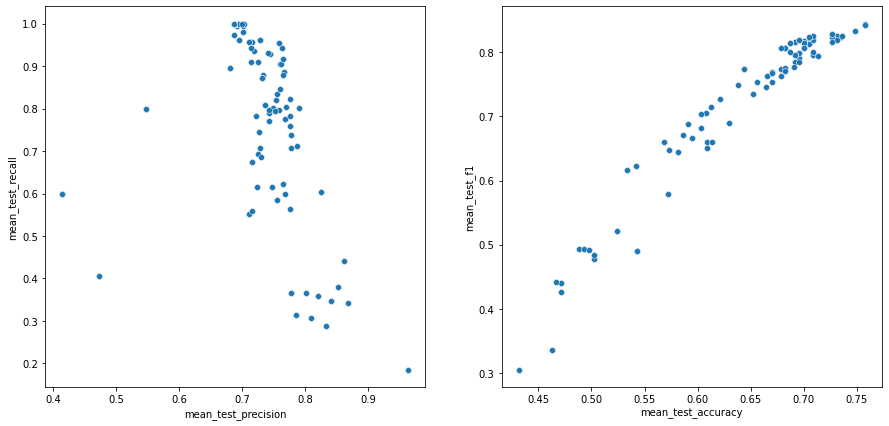

In [42]:
temp_df = exp_results_df[exp_results_df["mean_test_accuracy"]>=0.70].\
  sort_values(by="mean_test_accuracy", ascending=False)

for idx, row in temp_df.iterrows():
  print(round(row["mean_test_accuracy"], 3), row["params"])

print()

report_metrics(exp_results_df)

## Boosting + CountVectorizer

In [63]:
# BOOSTING
from sklearn.ensemble import GradientBoostingClassifier

# crear modelo combinado de n-gramas y random forest
column_trans = ColumnTransformer([
    # Applicar una transformación CountVectorizer a la columna 'cargos limpio'  
    ('CargosLimpioNGramas',  CountVectorizer(), 'cargos limpio')],
    remainder='drop' # ignore the remaining columns
)

pipeline = Pipeline([
    # Primer paso: extracción de características
    ("FeatureExtraction", column_trans),
    # Segundo paso: predicción de la decisión
    ('GBPred', GradientBoostingClassifier(random_state=0))
])

# especificación de hiperparámetros a optimizar
parameters = {
    #'FeatureExtraction__CargosLimpioNGramas__max_features': [50, None], # cant de features a extraer
    'FeatureExtraction__CargosLimpioNGramas__max_df': [1.0, 0.90], 
    'FeatureExtraction__CargosLimpioNGramas__min_df': [0.0, 0.10],
    'FeatureExtraction__CargosLimpioNGramas__ngram_range': [(1, 1), (1, 2), (2, 2)], # n-grams length
    'GBPred__subsample': [0.1, 0.9],
    #'GBPred__min_samples_leaf': [1, 3, 5],
    'GBPred__max_depth': [1, 2, 3],
    'GBPred__learning_rate': [0.1, 0.05]
}

In [64]:
exp_results_df = run_CV(pipeline, 
                        "N-gramas + GB", 
                        parameters, 
                        kf, 
                        X_train, Y_train)

#experiments_results = experiments_results.append(exp_results_df)

0.709 {'FeatureExtraction__CargosLimpioNGramas__max_df': 1.0, 'FeatureExtraction__CargosLimpioNGramas__min_df': 0.0, 'FeatureExtraction__CargosLimpioNGramas__ngram_range': (1, 2), 'GBPred__max_depth': 3, 'GBPred__subsample': 0.9}
0.709 {'FeatureExtraction__CargosLimpioNGramas__max_df': 0.9, 'FeatureExtraction__CargosLimpioNGramas__min_df': 0.0, 'FeatureExtraction__CargosLimpioNGramas__ngram_range': (1, 2), 'GBPred__max_depth': 3, 'GBPred__subsample': 0.9}
0.7 {'FeatureExtraction__CargosLimpioNGramas__max_df': 1.0, 'FeatureExtraction__CargosLimpioNGramas__min_df': 0.1, 'FeatureExtraction__CargosLimpioNGramas__ngram_range': (1, 1), 'GBPred__max_depth': 1, 'GBPred__subsample': 0.9}
0.7 {'FeatureExtraction__CargosLimpioNGramas__max_df': 0.9, 'FeatureExtraction__CargosLimpioNGramas__min_df': 0.1, 'FeatureExtraction__CargosLimpioNGramas__ngram_range': (1, 1), 'GBPred__max_depth': 1, 'GBPred__subsample': 0.9}



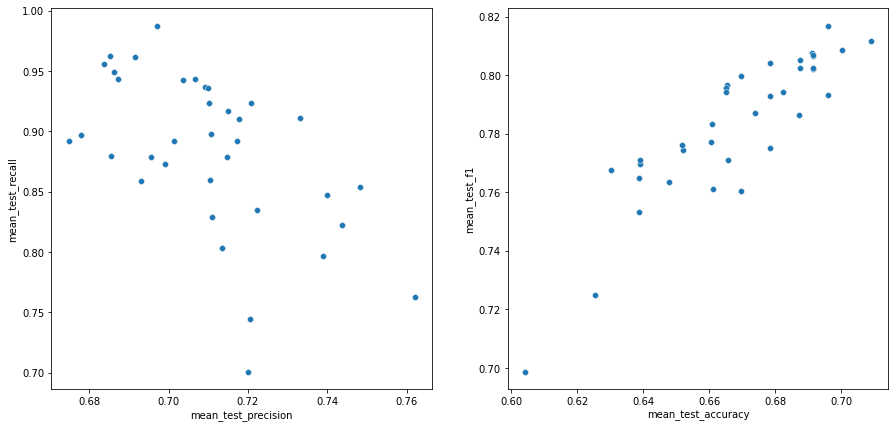

In [65]:
temp_df = exp_results_df[exp_results_df["mean_test_accuracy"]>=0.70].\
  sort_values(by="mean_test_accuracy", ascending=False)

for idx, row in temp_df.iterrows():
  print(round(row["mean_test_accuracy"], 3), row["params"])

print()

report_metrics(exp_results_df)

### Experimentos modelo RF + TF-IDF

In [43]:
# crear modelo combinado de n-gramas (TF-IDF) y random forest
column_trans_2 = ColumnTransformer([
    # Applicar una transformación TFIDF a la columna 'cargos'  
    ('CargosLimpiosTFIDF',  TfidfVectorizer(), 'cargos limpio')
    ],
    remainder='drop' # ignore the remaining columns
)

pipeline_2 = Pipeline([
    # Primer paso: extracción de características
    ("FeatureExtraction", column_trans_2),
    # Segundo paso: predicción de la decisión
    ('RandForestPred', RandomForestClassifier(random_state=0, criterion="entropy")) # freeze random state
])

In [44]:
# especificación de hiperparámetros a optimizar
parameters_2 = {
    # parámetros del la transformación de la columna Cargos Limpio
    'FeatureExtraction__CargosLimpiosTFIDF__ngram_range': [(1, 1), (1, 2), (2, 2)], # n-grams length
    #'FeatureExtraction__CargosLimpiosTFIDF__max_features': [50, None], # cant de features a extraer
    'FeatureExtraction__CargosLimpiosTFIDF__max_df': [1.0, 0.90], 
    'FeatureExtraction__CargosLimpiosTFIDF__min_df': [0.0, 0.10],

    'RandForestPred__min_samples_leaf':[3, 5],
    'RandForestPred__bootstrap': [True, False],
    'RandForestPred__max_samples': [0.90],
    'RandForestPred__class_weight': ['balanced'] # weighted is much better
}

In [45]:
exp_results_df = run_CV(pipeline_2, 
                        "TF-IDF + RF", 
                        parameters_2, 
                        kf, 
                        X_train, Y_train)

#experiments_results = experiments_results.append(exp_results_df)

0.718 {'FeatureExtraction__CargosLimpiosTFIDF__max_df': 1.0, 'FeatureExtraction__CargosLimpiosTFIDF__min_df': 0.0, 'FeatureExtraction__CargosLimpiosTFIDF__ngram_range': (1, 1), 'RandForestPred__bootstrap': False, 'RandForestPred__class_weight': 'balanced', 'RandForestPred__max_samples': 0.9, 'RandForestPred__min_samples_leaf': 3}
0.718 {'FeatureExtraction__CargosLimpiosTFIDF__max_df': 0.9, 'FeatureExtraction__CargosLimpiosTFIDF__min_df': 0.0, 'FeatureExtraction__CargosLimpiosTFIDF__ngram_range': (1, 1), 'RandForestPred__bootstrap': False, 'RandForestPred__class_weight': 'balanced', 'RandForestPred__max_samples': 0.9, 'RandForestPred__min_samples_leaf': 3}
0.718 {'FeatureExtraction__CargosLimpiosTFIDF__max_df': 1.0, 'FeatureExtraction__CargosLimpiosTFIDF__min_df': 0.0, 'FeatureExtraction__CargosLimpiosTFIDF__ngram_range': (1, 2), 'RandForestPred__bootstrap': False, 'RandForestPred__class_weight': 'balanced', 'RandForestPred__max_samples': 0.9, 'RandForestPred__min_samples_leaf': 3}
0.71

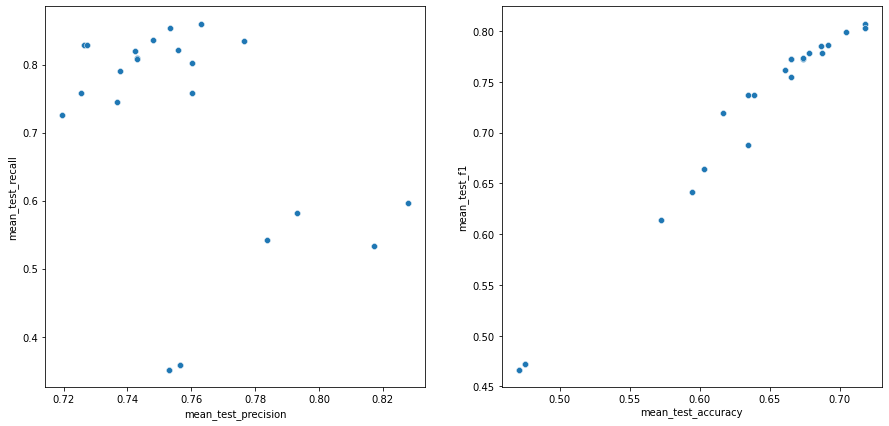

In [46]:
temp_df = exp_results_df[exp_results_df["mean_test_accuracy"]>=0.70].\
  sort_values(by="mean_test_accuracy", ascending=False)

for idx, row in temp_df.iterrows():
  print(round(row["mean_test_accuracy"], 3), row["params"])

print()

report_metrics(exp_results_df)

### Experimentos modelo SVC + TF-IDF

In [47]:
# crear modelo combinado de n-gramas (TF-IDF) y SVC
column_trans = ColumnTransformer([
    # Applicar una transformación TFIDF a la columna 'cargos'  
    ('CargosLimpiosTFIDF',  TfidfVectorizer(), 'cargos limpio')
    ],
    remainder='drop' # ignore the remaining columns
)

pipeline = Pipeline([
    # Primer paso: extracción de características
    ("FeatureExtraction", column_trans),
    # Segundo paso: predicción de la decisión
    ('SVMPred', SVC(random_state=0)) # freeze random state
])

In [48]:
# especificación de hiperparámetros a optimizar
parameters = {
    # parámetros del la transformación de la columna Cargos Limpio
    'FeatureExtraction__CargosLimpiosTFIDF__ngram_range': [(1, 1), (1, 2), (2, 2)], # n-grams length
    #'FeatureExtraction__CargosLimpiosTFIDF__max_features': [50, None], # cant de features a extraer
    'FeatureExtraction__CargosLimpiosTFIDF__max_df': [1.0, 0.90], 
    'FeatureExtraction__CargosLimpiosTFIDF__min_df': [0.0, 0.10],

    'SVMPred__C': [0.1, 1, 10], 
    'SVMPred__kernel':['linear', 'rbf'],
    'SVMPred__class_weight': ["balanced", None]
}

In [49]:
exp_results_df = run_CV(pipeline, 
                        "TF-IDF + SVC", 
                        parameters, 
                        kf, 
                        X_train, Y_train)

#experiments_results = experiments_results.append(exp_results_df)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

0.736 {'FeatureExtraction__CargosLimpiosTFIDF__max_df': 0.9, 'FeatureExtraction__CargosLimpiosTFIDF__min_df': 0.0, 'FeatureExtraction__CargosLimpiosTFIDF__ngram_range': (1, 2), 'SVMPred__C': 1, 'SVMPred__class_weight': 'balanced', 'SVMPred__kernel': 'linear'}
0.736 {'FeatureExtraction__CargosLimpiosTFIDF__max_df': 1.0, 'FeatureExtraction__CargosLimpiosTFIDF__min_df': 0.0, 'FeatureExtraction__CargosLimpiosTFIDF__ngram_range': (1, 2), 'SVMPred__C': 1, 'SVMPred__class_weight': 'balanced', 'SVMPred__kernel': 'linear'}
0.731 {'FeatureExtraction__CargosLimpiosTFIDF__max_df': 1.0, 'FeatureExtraction__CargosLimpiosTFIDF__min_df': 0.0, 'FeatureExtraction__CargosLimpiosTFIDF__ngram_range': (2, 2), 'SVMPred__C': 10, 'SVMPred__class_weight': 'balanced', 'SVMPred__kernel': 'linear'}
0.731 {'FeatureExtraction__CargosLimpiosTFIDF__max_df': 0.9, 'FeatureExtraction__CargosLimpiosTFIDF__min_df': 0.0, 'FeatureExtraction__CargosLimpiosTFIDF__ngram_range': (2, 2), 'SVMPred__C': 10, 'SVMPred__class_weight':

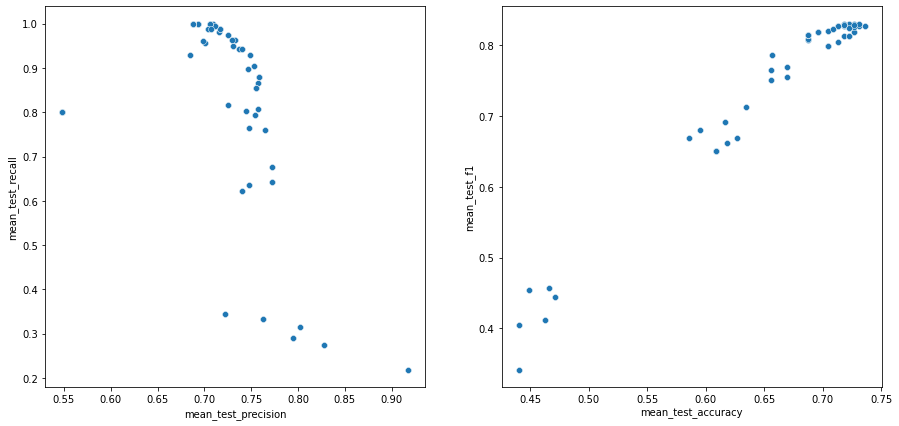

In [50]:
temp_df = exp_results_df[exp_results_df["mean_test_accuracy"]>=0.70].\
  sort_values(by="mean_test_accuracy", ascending=False)

for idx, row in temp_df.iterrows():
  print(round(row["mean_test_accuracy"], 3), row["params"])

print()

report_metrics(exp_results_df)

### Experimento Cargos Multicat + RF

In [ ]:
# entrenar el multi label binarizer
mlb = MultiLabelBinarizer(classes=cargos_list)
mlb.fit([cargos_list])

# hay algunos errores que se debe corregir en la codificación
X_train_proc = mlb.transform(X_train["códigos"])

print(X_train_proc.shape)

(227, 40)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['', 'o6', 'se11', 'se2', 'seg5\n', 'ser2ser7'] will be ignored
  .format(sorted(unknown, key=str)))


In [ ]:
# crear modelo combinado de cargos (multicat) y random forest

pipeline_3 = Pipeline([
    # predicción de la decisión
    ('RandForestPred', RandomForestClassifier(random_state=0)) # freeze random state
])

In [ ]:
# especificación de hiperparámetros a optimizar
parameters_3 = {
    'RandForestPred__criterion': ['entropy'], 
    'RandForestPred__min_samples_leaf':[3, 5, 7],
    'RandForestPred__bootstrap': [True, False],
    'RandForestPred__class_weight': ["balanced", None]
}

In [ ]:
exp_results_df = run_CV(pipeline_3, 
                        "CargosMulticat + RF", 
                        parameters_3, 
                        kf, 
                        X_train_proc, Y_train)

#experiments_results = experiments_results.append(exp_results_df)

0.687 {'RandForestPred__bootstrap': True, 'RandForestPred__class_weight': None, 'RandForestPred__criterion': 'entropy', 'RandForestPred__min_samples_leaf': 3}
0.687 {'RandForestPred__bootstrap': True, 'RandForestPred__class_weight': None, 'RandForestPred__criterion': 'entropy', 'RandForestPred__min_samples_leaf': 5}
0.687 {'RandForestPred__bootstrap': True, 'RandForestPred__class_weight': None, 'RandForestPred__criterion': 'entropy', 'RandForestPred__min_samples_leaf': 7}
0.687 {'RandForestPred__bootstrap': False, 'RandForestPred__class_weight': None, 'RandForestPred__criterion': 'entropy', 'RandForestPred__min_samples_leaf': 1}
0.687 {'RandForestPred__bootstrap': False, 'RandForestPred__class_weight': None, 'RandForestPred__criterion': 'entropy', 'RandForestPred__min_samples_leaf': 5}
0.687 {'RandForestPred__bootstrap': False, 'RandForestPred__class_weight': None, 'RandForestPred__criterion': 'entropy', 'RandForestPred__min_samples_leaf': 7}



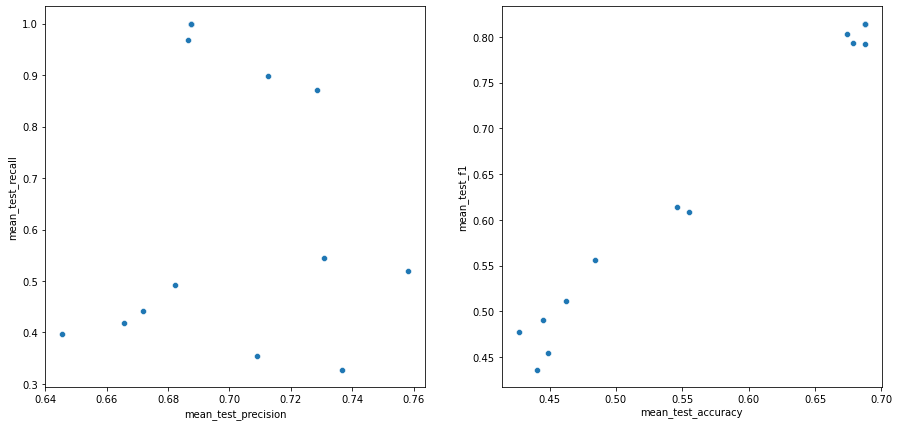

In [ ]:
temp_df = exp_results_df[exp_results_df["mean_test_accuracy"]>=0.68].\
  sort_values(by="mean_test_accuracy", ascending=False)

for idx, row in temp_df.iterrows():
  print(round(row["mean_test_accuracy"], 3), row["params"])

print()

report_metrics(exp_results_df)

### Experimento Cargos Multicat + SVC

In [ ]:
# crear modelo combinado de cargos (multicat) y SVM
pipeline = Pipeline([
    # predicción de la decisión
    ('SVMPred', SVC(random_state=0, class_weight="balanced")) # freeze random state
])

In [ ]:
# especificación de hiperparámetros a optimizar
parameters = {
    'SVMPred__C': [0.1, 1, 10], 
    'SVMPred__kernel':['linear', 'rbf'],
}

In [ ]:
exp_results_df = run_CV(pipeline, 
                        "CargosMulticat + SVM", 
                        parameters, 
                        kf, 
                        X_train_proc, Y_train)

experiments_results = experiments_results.append(exp_results_df)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## Guardar los resultados

In [ ]:
experiments_results.to_csv("resultados_experimentos.csv")